In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

In [2]:
input_window = 100
output_window = 5
batch_size = 32 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = ("cpu")

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):

        return x + self.pe[:x.size(0), :]

In [4]:
class TransAm(nn.Module):
    def __init__(self,feature_size=2,num_layers=3,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=1, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            # print('a',src.size())
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('j',src.size(),self.src_mask.size())
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)

        output = self.decoder(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [5]:
import pandas as pd
from datetime import date
# data_ = pd.read_excel('../data/LD_20142.xlsx', 'Sheet1', parse_dates=["date"])
data_ = pd.read_csv('dataset/test.CSV')
data_ = data_.fillna(0)

In [6]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    # print(L)
    np.zeros((output_window, 3))
    for i in range(L - tw):
        train_seq = np.append(input_data[i:i + tw, :][:-output_window, :], np.zeros((output_window, 2)), axis=0)
        train_label = input_data[i:i + tw, :]
        # print(train_seq.shape,train_label.shape)
        # train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)


def get_data():
    time = np.arange(0, 400, 0.1)
    # amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))

    # series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))

    data = data_.loc[:, "concentration":  "amount"]
    series = data.to_numpy()
    # print('a',series.shape)
    amplitude = scaler.fit_transform(series)
    # print('b', amplitude.shape)
    # amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    # print(amplitude.shape)
    sampels = 2800
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # print(train_data.shape,test_data.shape)
    # convert our train data into a pytorch train tensor
    # train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment..
    # print('c',train_data.shape)

    train_sequence = create_inout_sequences(train_data, input_window)
    # print('a',train_sequence.size())
    train_sequence = train_sequence[:-output_window]  # todo: fix hack?

    # test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]  # todo: fix hack?

    return train_sequence.to(device), test_data.to(device), scaler


def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i + seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1)).squeeze()  # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1)).squeeze()
    return input, target



In [7]:
train_data, val_data,scaler = get_data()
print(train_data.size())
# print(train_data.size(), val_data.size())
tr,te = get_batch(train_data, 0,batch_size)
print(tr.shape,te.shape)

D:\miniconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  from ipykernel import kernelapp as app


torch.Size([2695, 2, 100, 2])
torch.Size([100, 32, 2]) torch.Size([100, 32, 2])


In [8]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [9]:
def plot_and_loss(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)

            # look like the model returns static values for the output window
            output = eval_model(data)   

            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    print(test_result.size(),truth.size())
    test_result=scaler.inverse_transform(test_result.reshape(-1, 1)).reshape(-1)
    truth=scaler.inverse_transform(truth.reshape(-1, 1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.axhline(y=0, color='k')
    pyplot.xlabel("Periods")
    pyplot.ylabel("Y")
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


def predict_future(eval_model, data_source,steps,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    
    data=scaler.inverse_transform(data.reshape(-1, 1)).reshape(-1)
    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%epoch)
    pyplot.close()
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data) 
            print(output[-output_window:].size(),targets[-output_window:].size())
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

In [10]:
def plot(eval_model, data_source,epoch,scaler):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)            
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)
    
    test_result_=scaler.inverse_transform(test_result[:700])
    truth_=scaler.inverse_transform(truth)
    print(test_result.shape,truth.shape)
    for m in range(2):
        test_result = test_result_[:,m]
        truth = truth_[:,m]
        fig = pyplot.figure(1, figsize=(20, 5))
        fig.patch.set_facecolor('xkcd:white')
        pyplot.plot(truth[:700],color="black")

        pyplot.plot([k + 510                 for k in range(190)],test_result[510:],color="red")
        pyplot.title('Prediction uncertainty')
        pyplot.legend(["prediction", "true"], loc="upper left")
        ymin, ymax = pyplot.ylim()
        pyplot.vlines(510, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        pyplot.ylim(ymin, ymax)
        pyplot.xlabel("Periods")
        pyplot.ylabel("Y")
        pyplot.show()
        pyplot.close()
    return total_loss / i

D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |    16/   84 batches | lr 0.005000 | 964.62 ms | loss 0.38196 | ppl     1.47
| epoch   1 |    32/   84 batches | lr 0.005000 | 901.81 ms | loss 0.26918 | ppl     1.31
| epoch   1 |    48/   84 batches | lr 0.005000 | 921.69 ms | loss 0.04789 | ppl     1.05
| epoch   1 |    64/   84 batches | lr 0.005000 | 971.02 ms | loss 0.01309 | ppl     1.01
| epoch   1 |    80/   84 batches | lr 0.005000 | 915.57 ms | loss 0.00935 | ppl     1.01
torch.Size([2096, 2]) torch.Size([2096, 2])


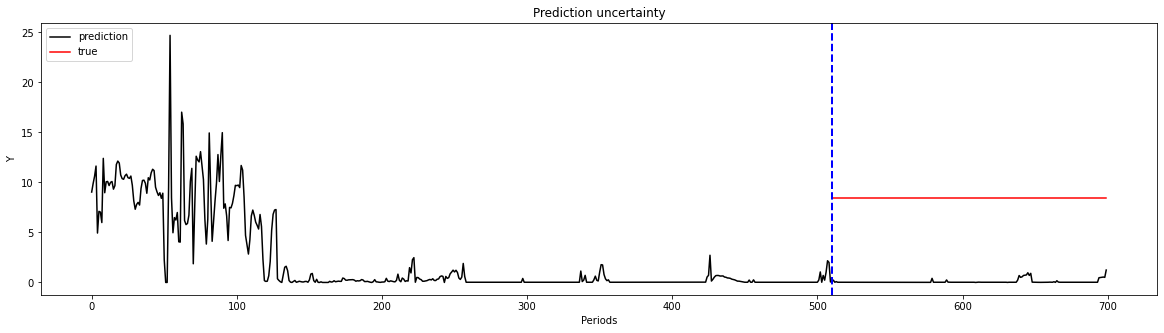

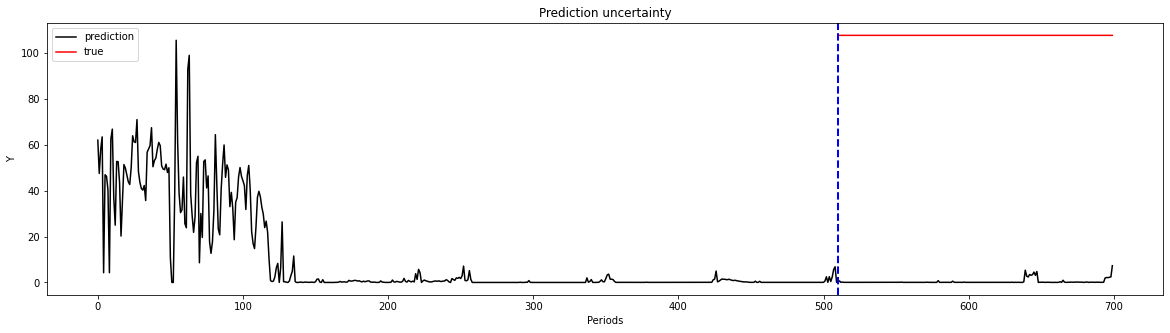

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 89.46s | valid loss 0.03397 | valid ppl     1.03
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   2 |    16/   84 batches | lr 0.004802 | 963.99 ms | loss 0.07995 | ppl     1.08
| epoch   2 |    32/   84 batches | lr 0.004802 | 905.10 ms | loss 0.09357 | ppl     1.10
| epoch   2 |    48/   84 batches | lr 0.004802 | 927.87 ms | loss 0.02396 | ppl     1.02
| epoch   2 |    64/   84 batches | lr 0.004802 | 979.48 ms | loss 0.00673 | ppl     1.01
| epoch   2 |    80/   84 batches | lr 0.004802 | 897.36 ms | loss 0.00132 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


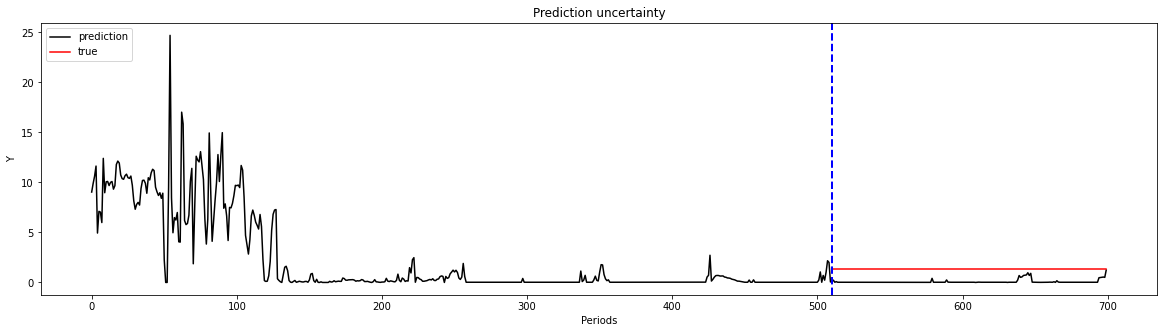

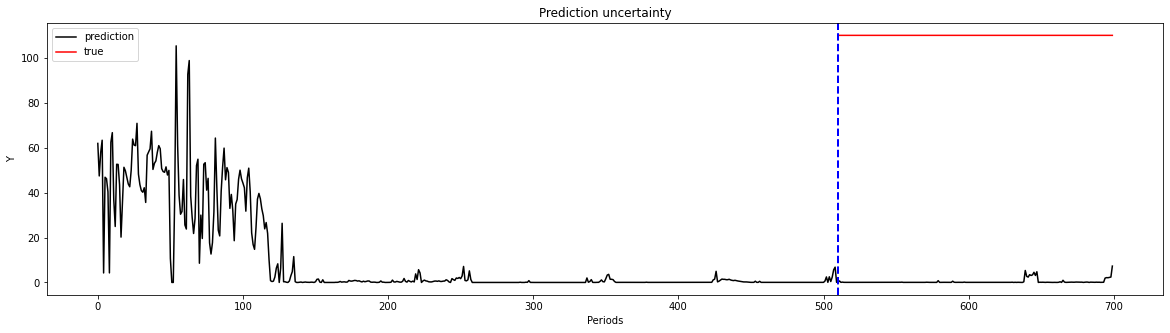

-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 89.74s | valid loss 0.03442 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   3 |    16/   84 batches | lr 0.004706 | 969.01 ms | loss 0.07571 | ppl     1.08
| epoch   3 |    32/   84 batches | lr 0.004706 | 904.11 ms | loss 0.08208 | ppl     1.09
| epoch   3 |    48/   84 batches | lr 0.004706 | 908.47 ms | loss 0.01782 | ppl     1.02
| epoch   3 |    64/   84 batches | lr 0.004706 | 969.74 ms | loss 0.00652 | ppl     1.01
| epoch   3 |    80/   84 batches | lr 0.004706 | 931.32 ms | loss 0.00124 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


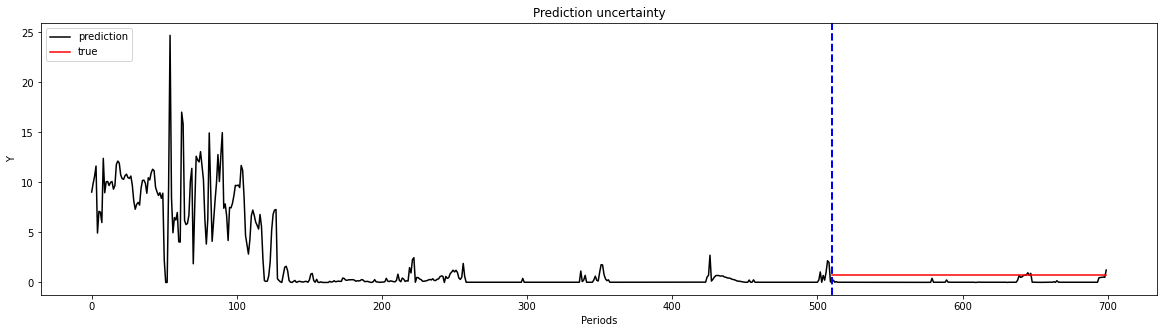

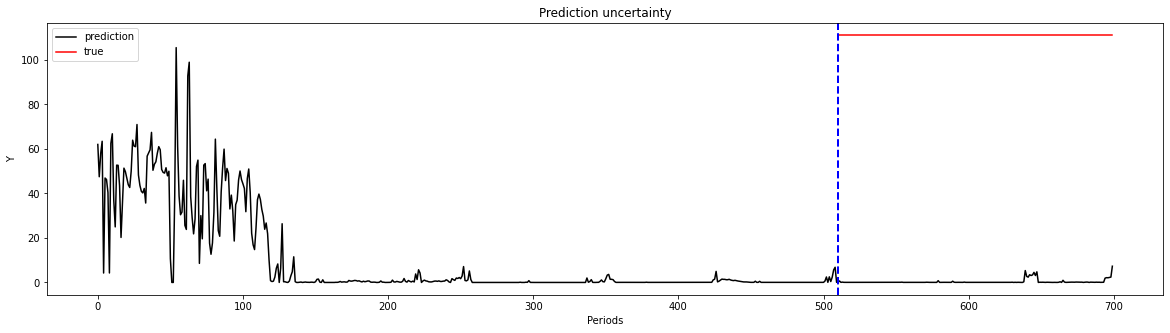

-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 89.72s | valid loss 0.03449 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   4 |    16/   84 batches | lr 0.004612 | 973.43 ms | loss 0.07654 | ppl     1.08
| epoch   4 |    32/   84 batches | lr 0.004612 | 902.55 ms | loss 0.07827 | ppl     1.08
| epoch   4 |    48/   84 batches | lr 0.004612 | 933.24 ms | loss 0.01720 | ppl     1.02
| epoch   4 |    64/   84 batches | lr 0.004612 | 964.50 ms | loss 0.00634 | ppl     1.01
| epoch   4 |    80/   84 batches | lr 0.004612 | 935.93 ms | loss 0.00123 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


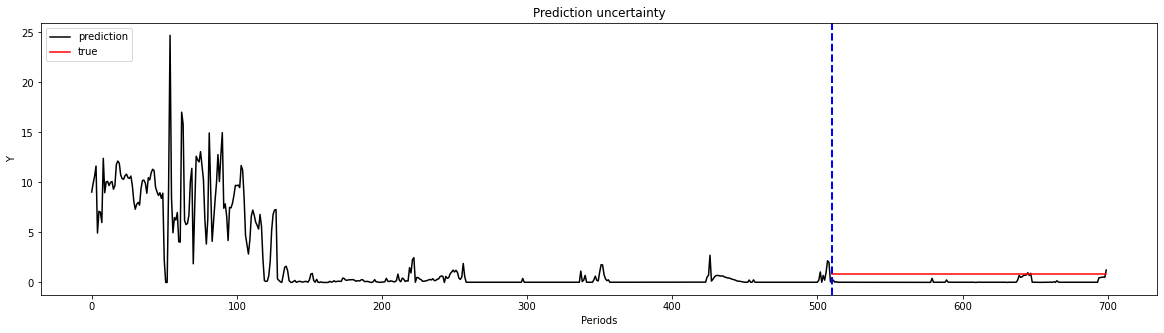

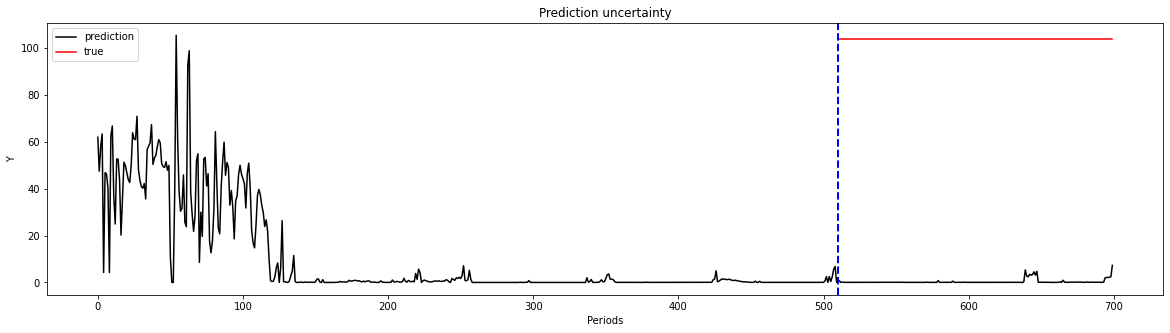

-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 89.95s | valid loss 0.03451 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   5 |    16/   84 batches | lr 0.004520 | 971.72 ms | loss 0.07763 | ppl     1.08
| epoch   5 |    32/   84 batches | lr 0.004520 | 899.98 ms | loss 0.07460 | ppl     1.08
| epoch   5 |    48/   84 batches | lr 0.004520 | 916.84 ms | loss 0.01655 | ppl     1.02
| epoch   5 |    64/   84 batches | lr 0.004520 | 943.04 ms | loss 0.00615 | ppl     1.01
| epoch   5 |    80/   84 batches | lr 0.004520 | 980.14 ms | loss 0.00126 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


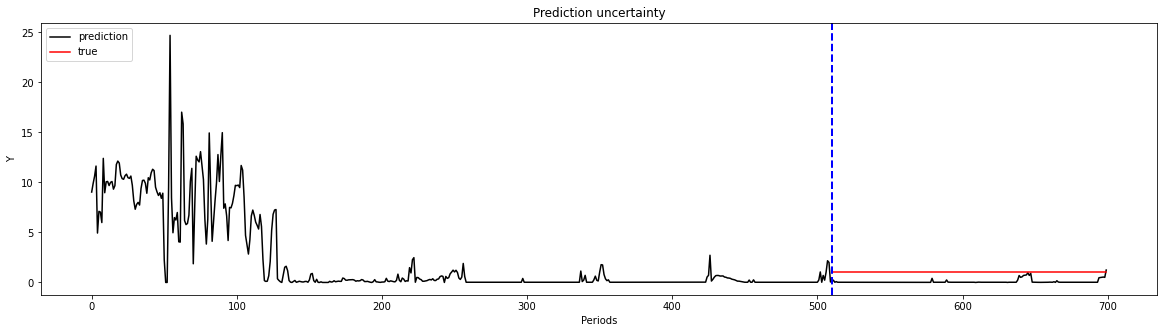

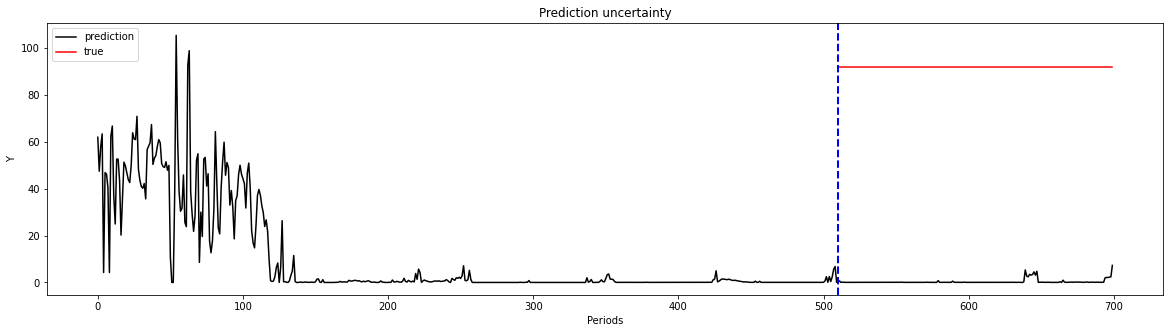

-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 91.77s | valid loss 0.03454 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   6 |    16/   84 batches | lr 0.004429 | 1023.28 ms | loss 0.07895 | ppl     1.08
| epoch   6 |    32/   84 batches | lr 0.004429 | 954.19 ms | loss 0.07115 | ppl     1.07
| epoch   6 |    48/   84 batches | lr 0.004429 | 919.20 ms | loss 0.01594 | ppl     1.02
| epoch   6 |    64/   84 batches | lr 0.004429 | 889.06 ms | loss 0.00596 | ppl     1.01
| epoch   6 |    80/   84 batches | lr 0.004429 | 874.22 ms | loss 0.00130 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


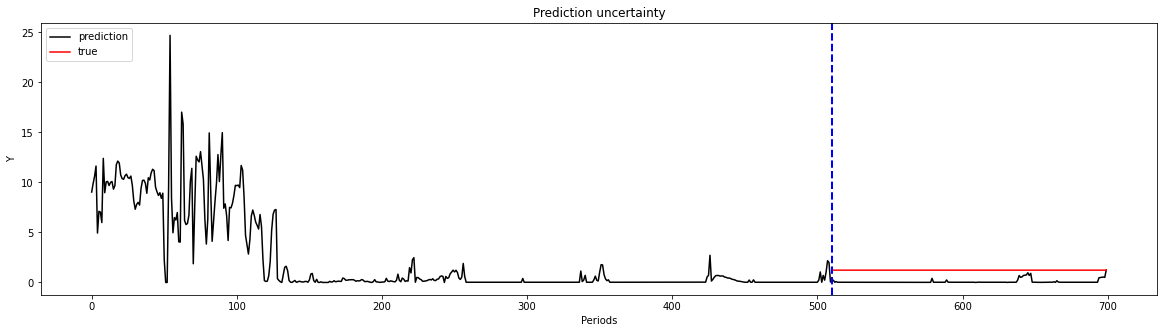

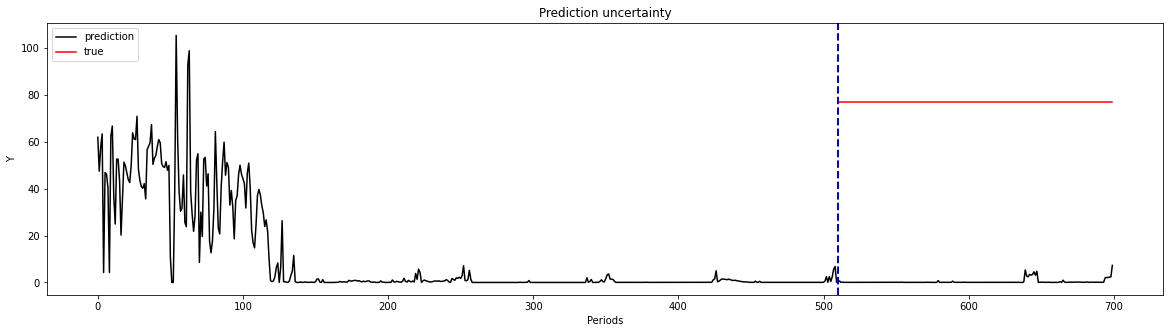

-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 88.64s | valid loss 0.03459 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   7 |    16/   84 batches | lr 0.004341 | 965.49 ms | loss 0.08041 | ppl     1.08
| epoch   7 |    32/   84 batches | lr 0.004341 | 905.77 ms | loss 0.06793 | ppl     1.07
| epoch   7 |    48/   84 batches | lr 0.004341 | 908.22 ms | loss 0.01537 | ppl     1.02
| epoch   7 |    64/   84 batches | lr 0.004341 | 908.41 ms | loss 0.00577 | ppl     1.01
| epoch   7 |    80/   84 batches | lr 0.004341 | 911.47 ms | loss 0.00136 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


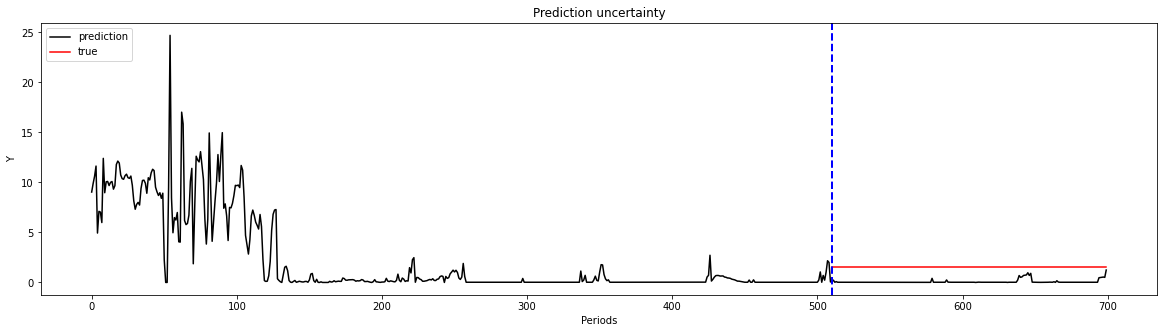

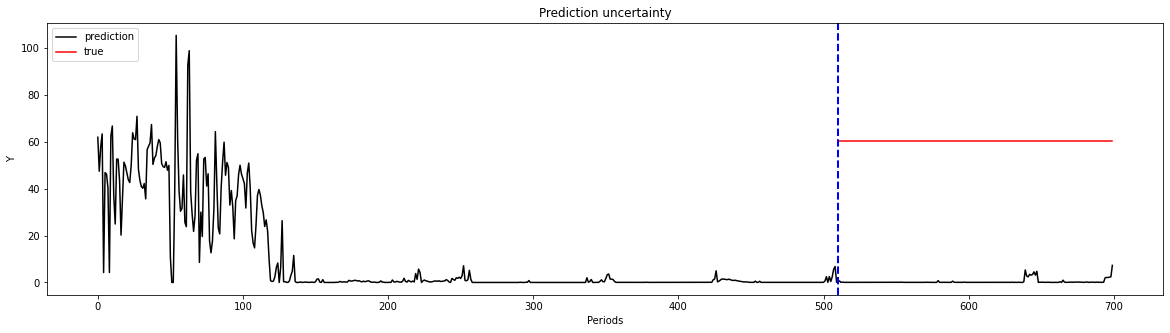

-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 88.90s | valid loss 0.03465 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   8 |    16/   84 batches | lr 0.004254 | 959.13 ms | loss 0.08197 | ppl     1.09
| epoch   8 |    32/   84 batches | lr 0.004254 | 904.49 ms | loss 0.06488 | ppl     1.07
| epoch   8 |    48/   84 batches | lr 0.004254 | 911.58 ms | loss 0.01481 | ppl     1.01
| epoch   8 |    64/   84 batches | lr 0.004254 | 909.59 ms | loss 0.00559 | ppl     1.01
| epoch   8 |    80/   84 batches | lr 0.004254 | 903.00 ms | loss 0.00141 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


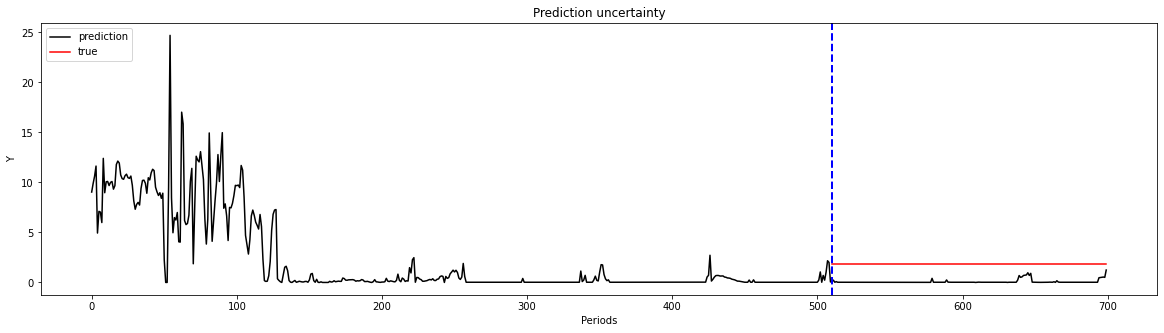

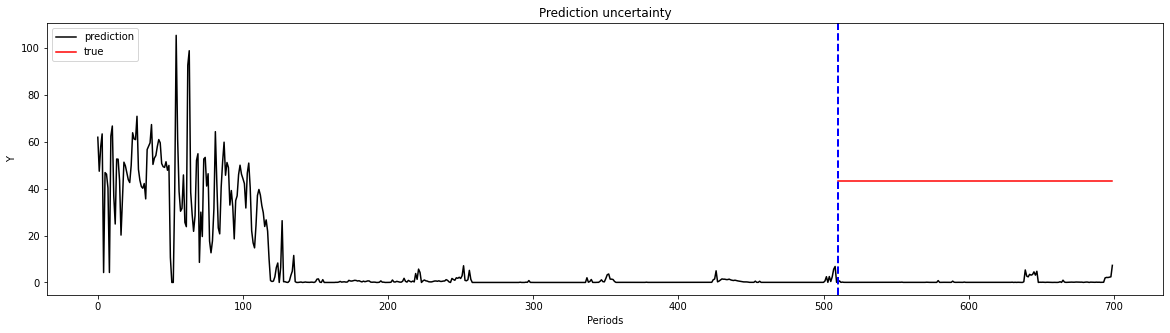

-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 88.70s | valid loss 0.03471 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   9 |    16/   84 batches | lr 0.004169 | 1003.18 ms | loss 0.08359 | ppl     1.09
| epoch   9 |    32/   84 batches | lr 0.004169 | 934.34 ms | loss 0.06191 | ppl     1.06
| epoch   9 |    48/   84 batches | lr 0.004169 | 901.39 ms | loss 0.01426 | ppl     1.01
| epoch   9 |    64/   84 batches | lr 0.004169 | 905.00 ms | loss 0.00543 | ppl     1.01
| epoch   9 |    80/   84 batches | lr 0.004169 | 904.10 ms | loss 0.00145 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


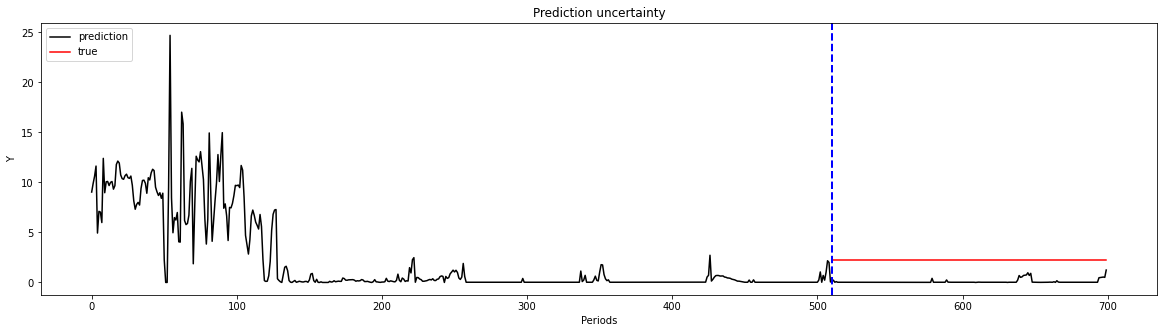

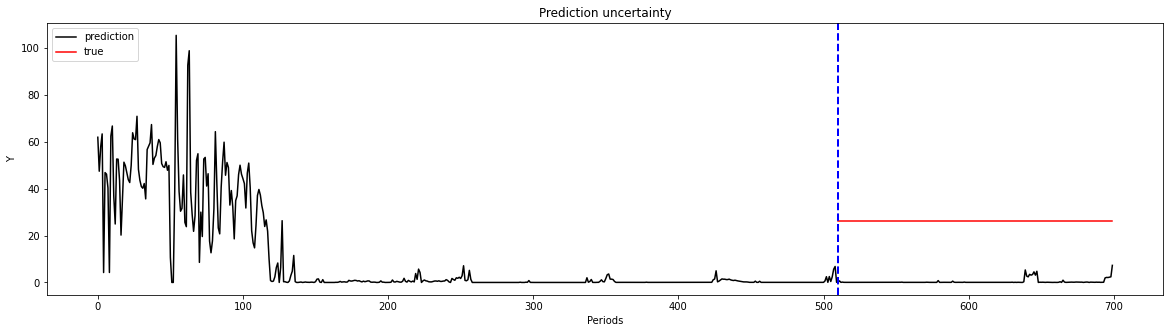

-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 89.77s | valid loss 0.03478 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  10 |    16/   84 batches | lr 0.004085 | 997.74 ms | loss 0.08525 | ppl     1.09
| epoch  10 |    32/   84 batches | lr 0.004085 | 916.11 ms | loss 0.05904 | ppl     1.06
| epoch  10 |    48/   84 batches | lr 0.004085 | 893.81 ms | loss 0.01371 | ppl     1.01
| epoch  10 |    64/   84 batches | lr 0.004085 | 908.72 ms | loss 0.00528 | ppl     1.01
| epoch  10 |    80/   84 batches | lr 0.004085 | 928.58 ms | loss 0.00149 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


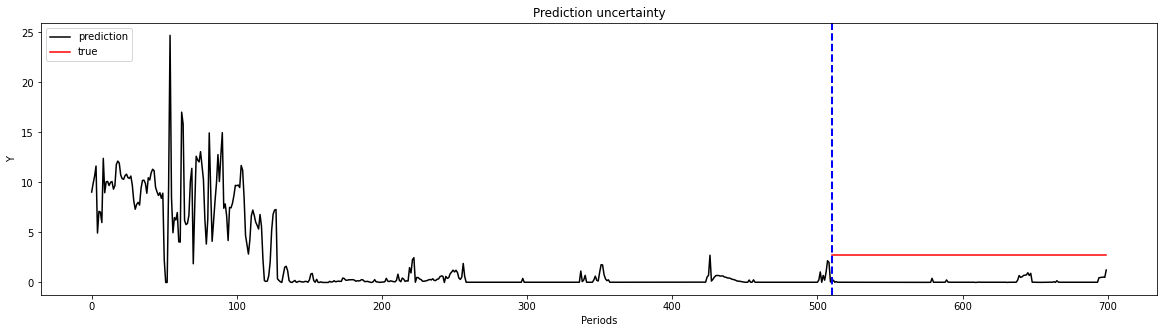

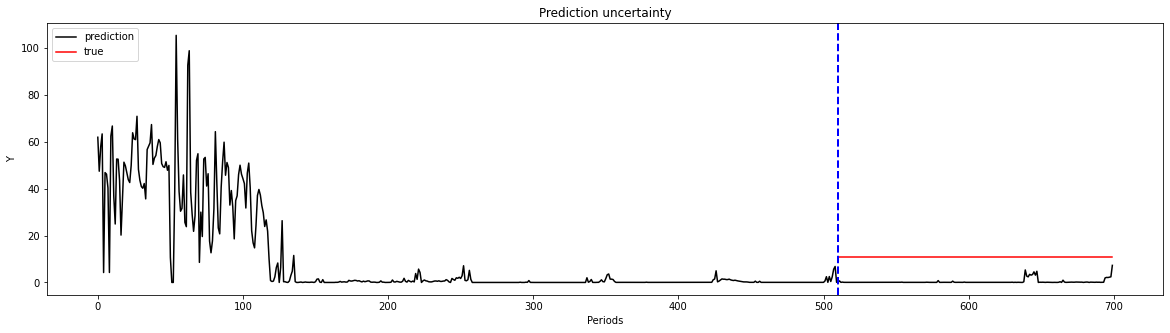

-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 89.40s | valid loss 0.03483 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  11 |    16/   84 batches | lr 0.004004 | 1009.92 ms | loss 0.08689 | ppl     1.09
| epoch  11 |    32/   84 batches | lr 0.004004 | 903.35 ms | loss 0.05630 | ppl     1.06
| epoch  11 |    48/   84 batches | lr 0.004004 | 904.74 ms | loss 0.01318 | ppl     1.01
| epoch  11 |    64/   84 batches | lr 0.004004 | 902.07 ms | loss 0.00516 | ppl     1.01
| epoch  11 |    80/   84 batches | lr 0.004004 | 903.03 ms | loss 0.00151 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


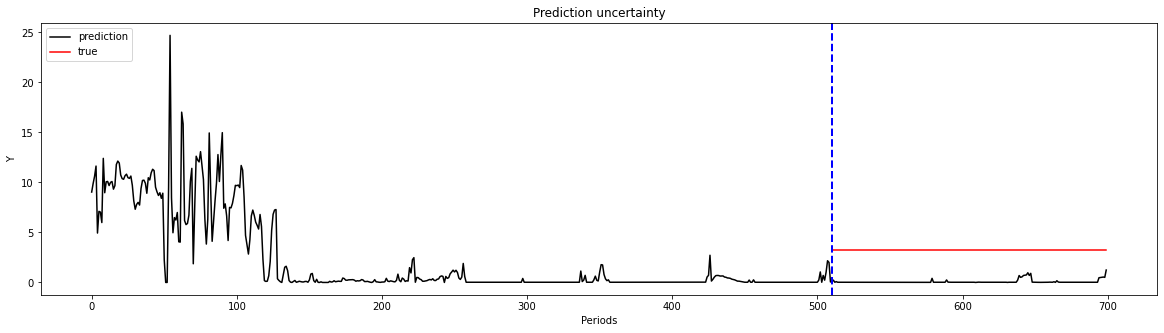

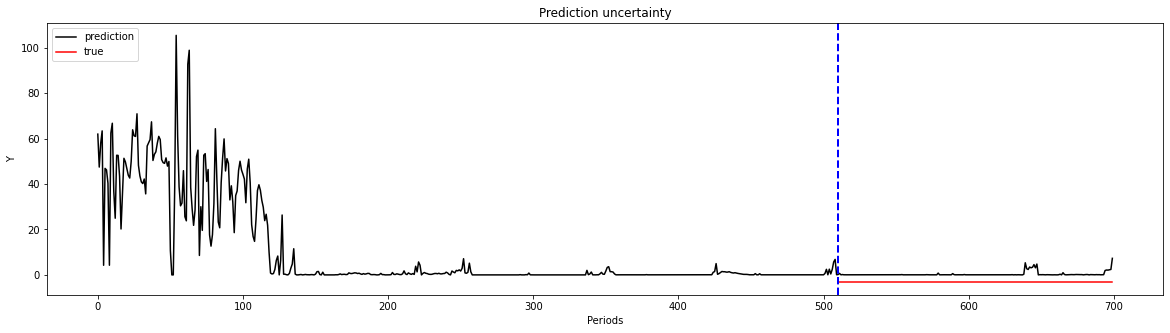

-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 88.80s | valid loss 0.03488 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  12 |    16/   84 batches | lr 0.003924 | 1032.41 ms | loss 0.08849 | ppl     1.09
| epoch  12 |    32/   84 batches | lr 0.003924 | 902.10 ms | loss 0.05370 | ppl     1.06
| epoch  12 |    48/   84 batches | lr 0.003924 | 916.93 ms | loss 0.01267 | ppl     1.01
| epoch  12 |    64/   84 batches | lr 0.003924 | 912.44 ms | loss 0.00506 | ppl     1.01
| epoch  12 |    80/   84 batches | lr 0.003924 | 908.38 ms | loss 0.00152 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


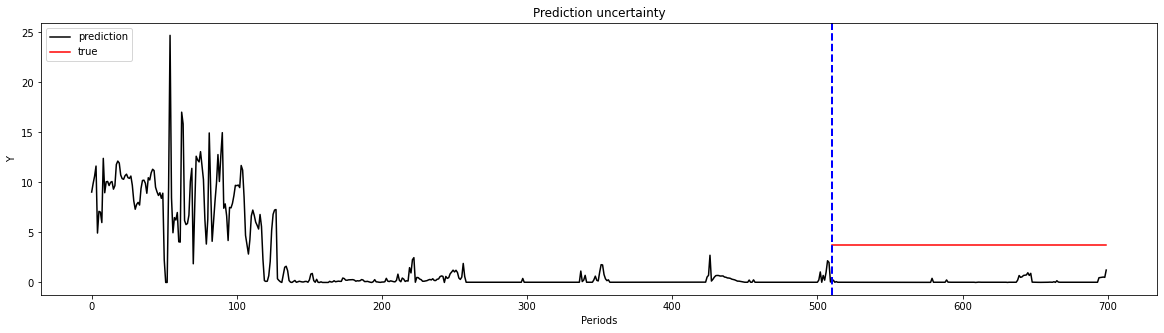

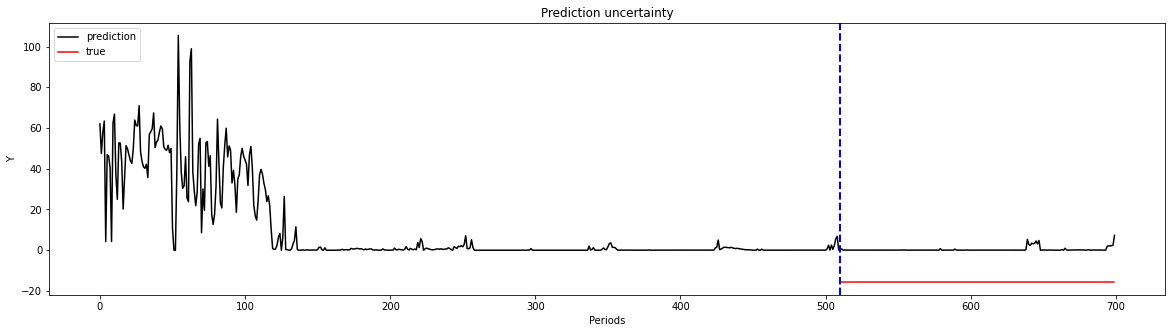

-----------------------------------------------------------------------------------------
| end of epoch  12 | time: 88.97s | valid loss 0.03492 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  13 |    16/   84 batches | lr 0.003845 | 1044.98 ms | loss 0.09004 | ppl     1.09
| epoch  13 |    32/   84 batches | lr 0.003845 | 917.89 ms | loss 0.05126 | ppl     1.05
| epoch  13 |    48/   84 batches | lr 0.003845 | 899.64 ms | loss 0.01220 | ppl     1.01
| epoch  13 |    64/   84 batches | lr 0.003845 | 901.72 ms | loss 0.00498 | ppl     1.00
| epoch  13 |    80/   84 batches | lr 0.003845 | 906.18 ms | loss 0.00152 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


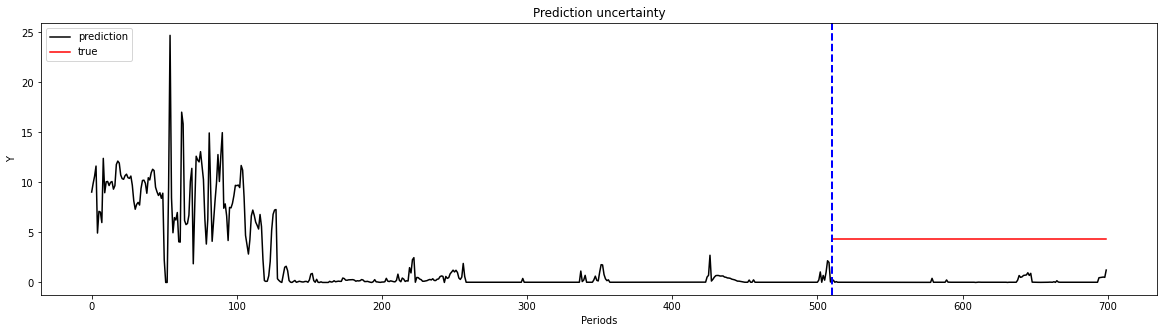

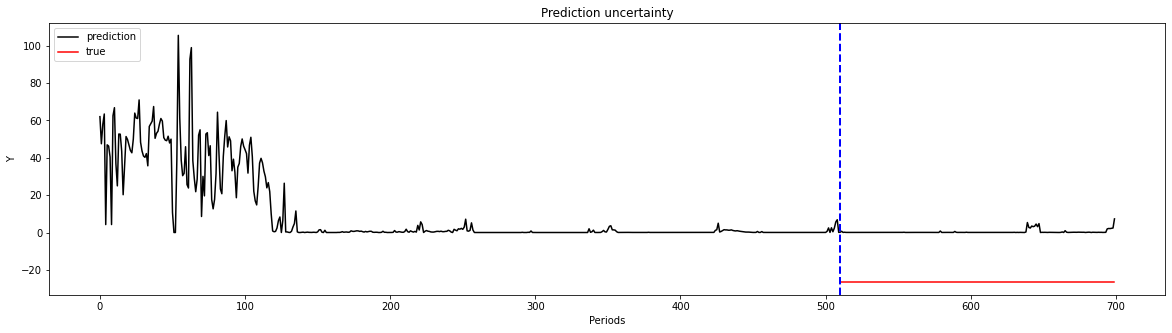

-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 91.09s | valid loss 0.03496 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  14 |    16/   84 batches | lr 0.003768 | 1043.03 ms | loss 0.09151 | ppl     1.10
| epoch  14 |    32/   84 batches | lr 0.003768 | 940.66 ms | loss 0.04902 | ppl     1.05
| epoch  14 |    48/   84 batches | lr 0.003768 | 907.91 ms | loss 0.01179 | ppl     1.01
| epoch  14 |    64/   84 batches | lr 0.003768 | 909.67 ms | loss 0.00491 | ppl     1.00
| epoch  14 |    80/   84 batches | lr 0.003768 | 895.42 ms | loss 0.00150 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


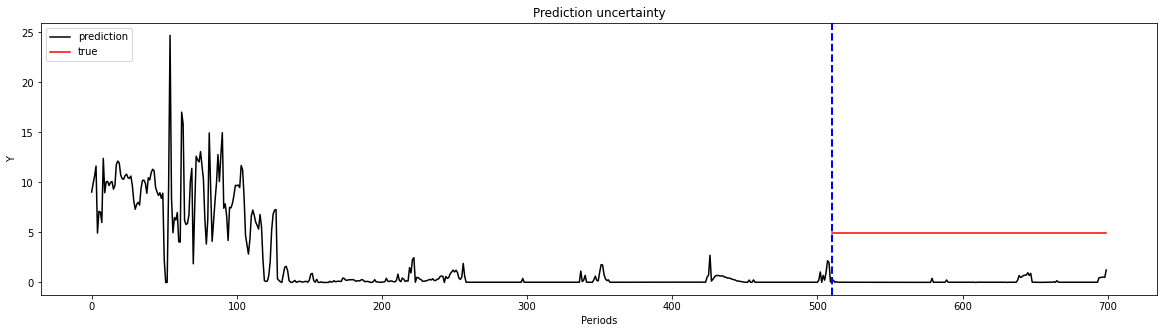

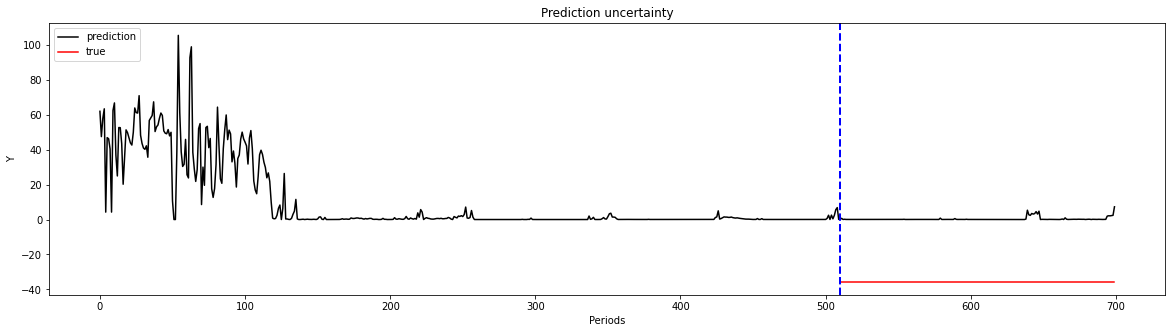

-----------------------------------------------------------------------------------------
| end of epoch  14 | time: 89.20s | valid loss 0.03499 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  15 |    16/   84 batches | lr 0.003693 | 984.89 ms | loss 0.09290 | ppl     1.10
| epoch  15 |    32/   84 batches | lr 0.003693 | 953.93 ms | loss 0.04704 | ppl     1.05
| epoch  15 |    48/   84 batches | lr 0.003693 | 905.83 ms | loss 0.01146 | ppl     1.01
| epoch  15 |    64/   84 batches | lr 0.003693 | 900.70 ms | loss 0.00487 | ppl     1.00
| epoch  15 |    80/   84 batches | lr 0.003693 | 897.31 ms | loss 0.00148 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


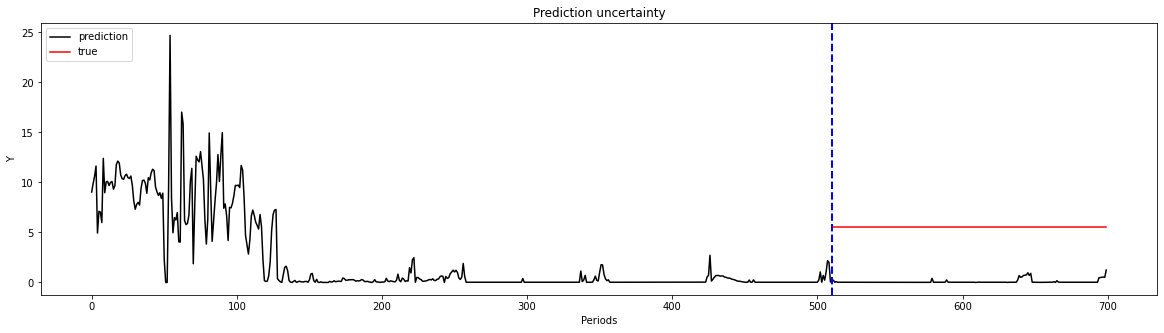

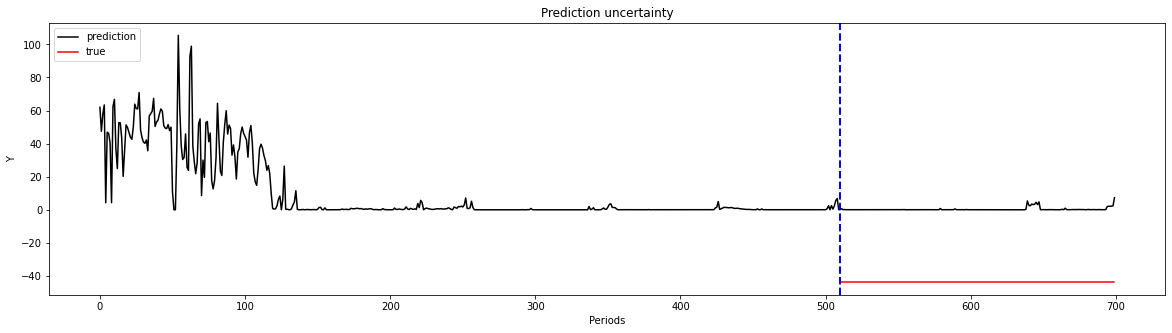

-----------------------------------------------------------------------------------------
| end of epoch  15 | time: 89.07s | valid loss 0.03501 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  16 |    16/   84 batches | lr 0.003619 | 967.71 ms | loss 0.09421 | ppl     1.10
| epoch  16 |    32/   84 batches | lr 0.003619 | 975.86 ms | loss 0.04521 | ppl     1.05
| epoch  16 |    48/   84 batches | lr 0.003619 | 910.08 ms | loss 0.01115 | ppl     1.01
| epoch  16 |    64/   84 batches | lr 0.003619 | 908.67 ms | loss 0.00484 | ppl     1.00
| epoch  16 |    80/   84 batches | lr 0.003619 | 908.38 ms | loss 0.00144 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


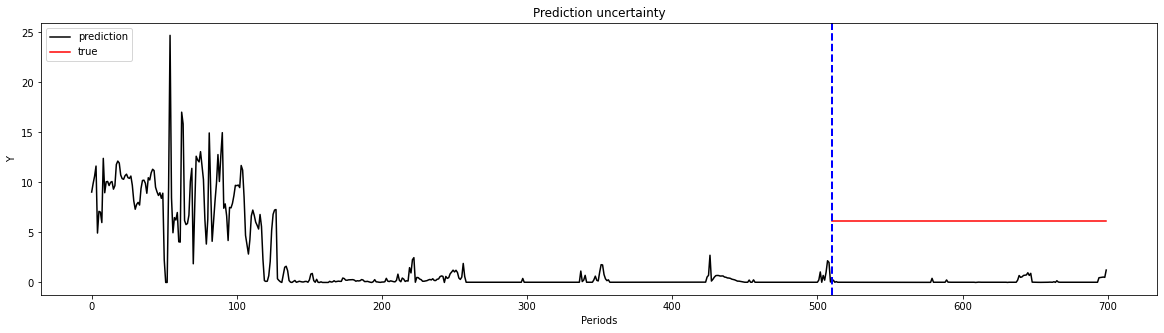

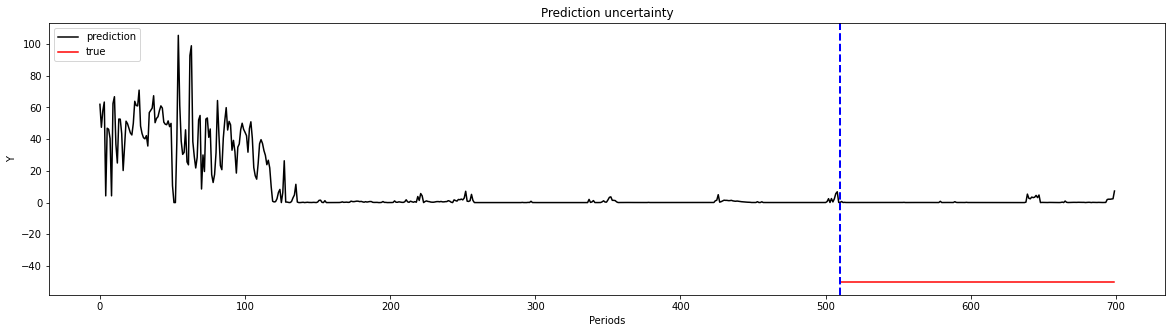

-----------------------------------------------------------------------------------------
| end of epoch  16 | time: 88.97s | valid loss 0.03503 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  17 |    16/   84 batches | lr 0.003547 | 955.76 ms | loss 0.09543 | ppl     1.10
| epoch  17 |    32/   84 batches | lr 0.003547 | 884.79 ms | loss 0.04353 | ppl     1.04
| epoch  17 |    48/   84 batches | lr 0.003547 | 875.87 ms | loss 0.01089 | ppl     1.01
| epoch  17 |    64/   84 batches | lr 0.003547 | 912.96 ms | loss 0.00483 | ppl     1.00
| epoch  17 |    80/   84 batches | lr 0.003547 | 903.56 ms | loss 0.00140 | ppl     1.00
torch.Size([2096, 2]) torch.Size([2096, 2])


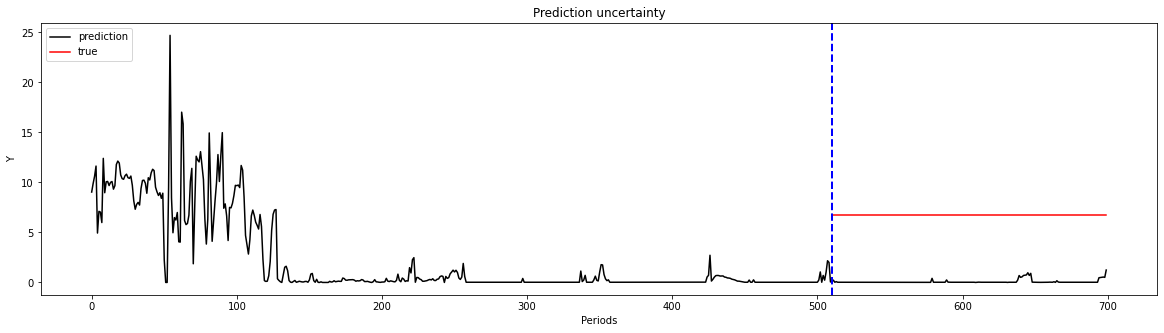

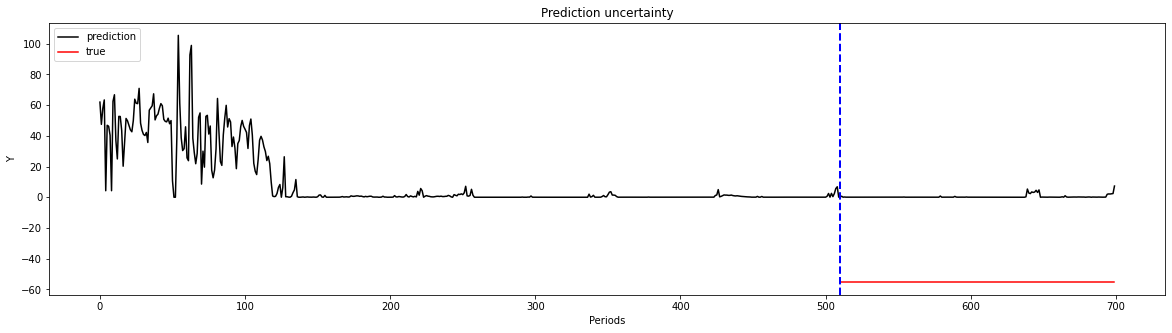

-----------------------------------------------------------------------------------------
| end of epoch  17 | time: 86.77s | valid loss 0.03505 | valid ppl     1.04
-----------------------------------------------------------------------------------------


D:\miniconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch  18 |    16/   84 batches | lr 0.003476 | 962.53 ms | loss 0.09658 | ppl     1.10
| epoch  18 |    32/   84 batches | lr 0.003476 | 907.55 ms | loss 0.04207 | ppl     1.04
| epoch  18 |    48/   84 batches | lr 0.003476 | 944.47 ms | loss 0.01070 | ppl     1.01
| epoch  18 |    64/   84 batches | lr 0.003476 | 951.90 ms | loss 0.00483 | ppl     1.00


In [ ]:
train_data, val_data,scaler = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 1 is 0):
        val_loss = plot(model, val_data,epoch,scaler)
        # predict_future(model, val_data,200,epoch,scaler)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 